# Data Preprocessing + Training
Dataset: CU-BEMS, smart building energy and IAQ data  
Source: [Kaggle](https://www.kaggle.com/datasets/claytonmiller/cubems-smart-building-energy-and-iaq-data)  
Author: Purugganan, Axle Rhon Q.  
Date: July 2025  

## Objective
- Prepare the dataset for training. Convert Power (kW) to Energy (kWh)

In [31]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_pickle('cleaned_z2_AC2_Floor2.pickle.gz')

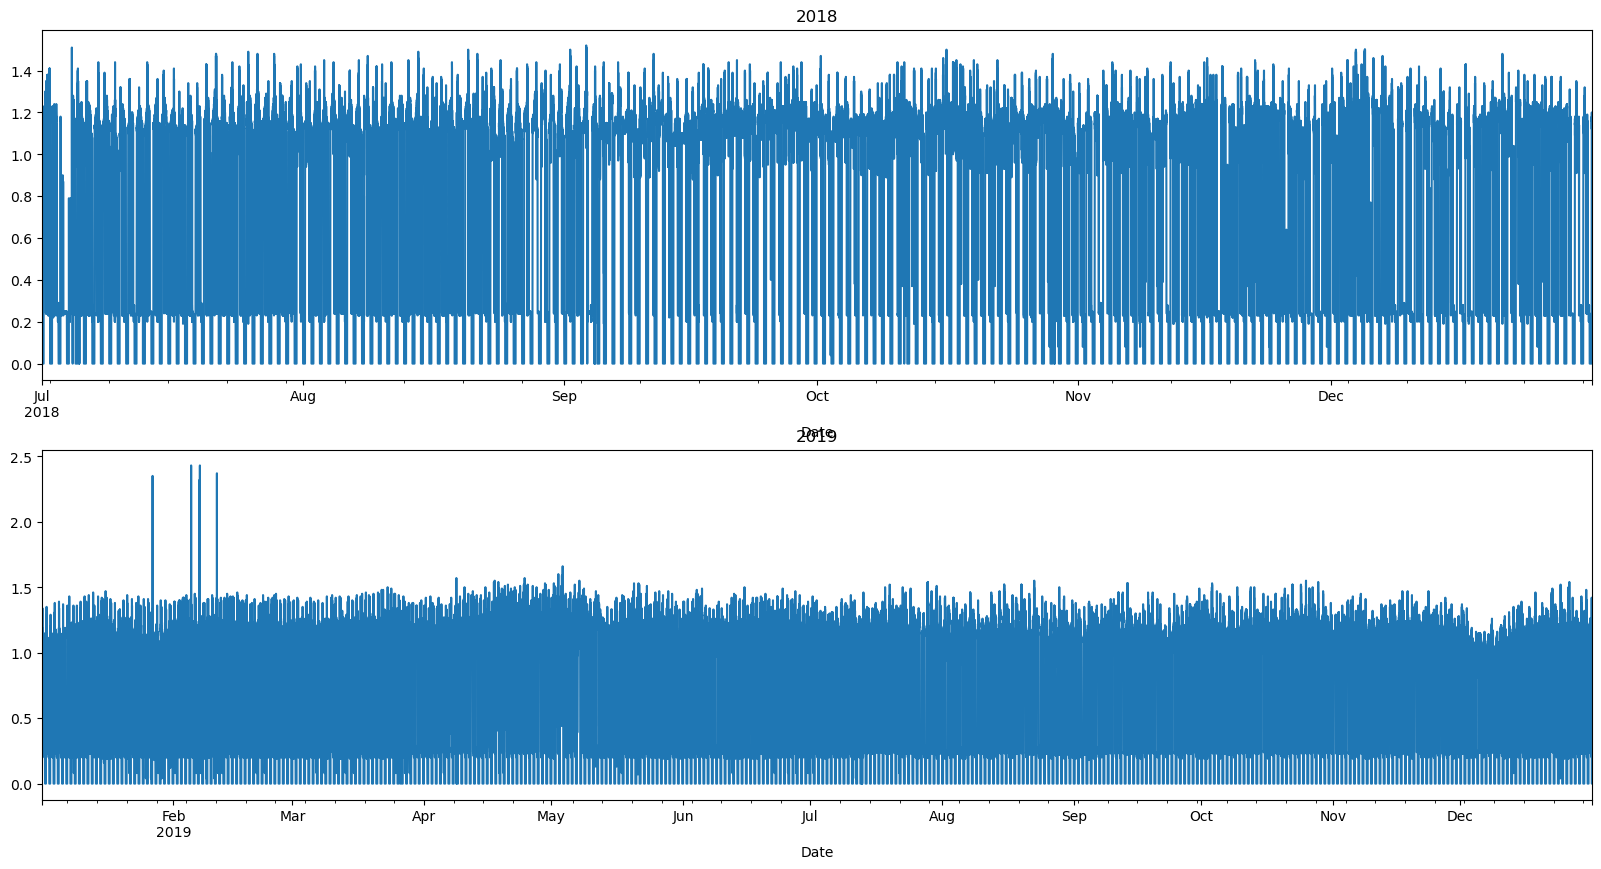

In [3]:
cols = df.columns
fig, axs = plt.subplots(2, 1, figsize=(20,10))
df[cols[0]].loc[df.index < '2019'].plot(title='2018', ax=axs[0])
df[cols[0]].loc[df.index > '2019'].plot(title='2019', ax=axs[1])
plt.tight_layout
plt.show()

In [4]:
df.shape

(790560, 4)

In [5]:
df.describe()

,z2_AC2(kW)_imputed,hour,dayofweek,month
count,790560.000000,790560.000000,790560.000000,790560.000000
mean,0.628207,11.500000,2.996357,7.520947
std,0.527728,6.922191,2.004547,3.294035
min,0.000000,0.000000,0.000000,1.000000
25%,0.230000,5.750000,1.000000,5.000000
50%,0.250000,11.500000,3.000000,8.000000
75%,1.170000,17.250000,5.000000,10.000000
max,2.430000,23.000000,6.000000,12.000000


## Feature Extraction & Engineering

### Convert Power (kW) to Energy (kWh)

Energy = Power * Time (Hour)

Timeseries Frequency = 1-min interval = 1/60 Hour

In [6]:
# Feature Extraction
df.insert(0, 'z2_AC2(kWh)', df['z2_AC2(kW)_imputed']*(1/60))

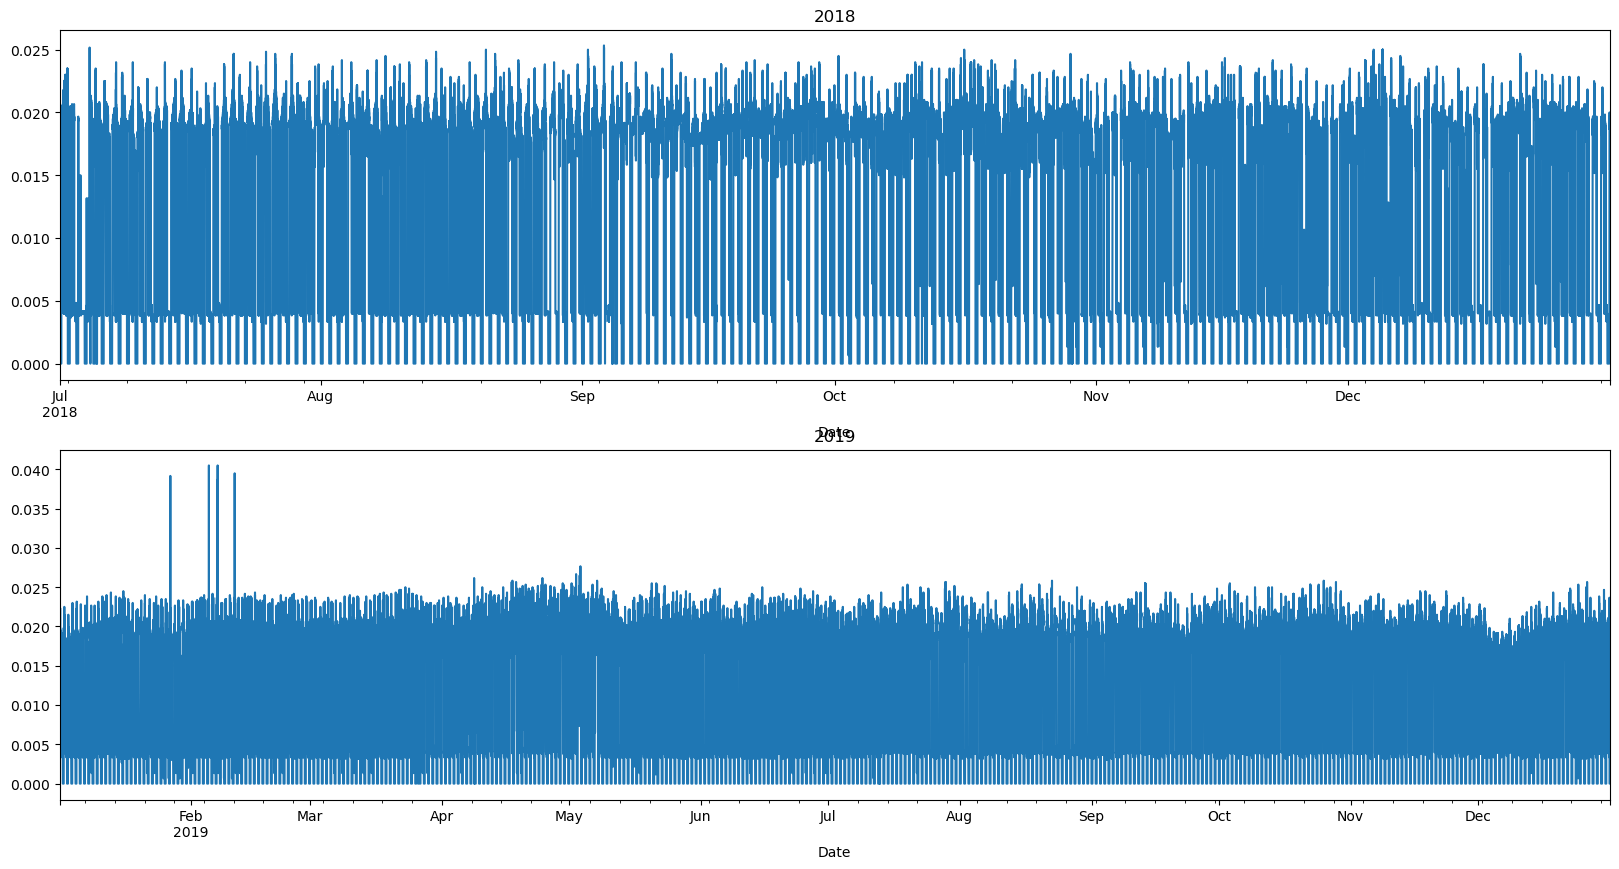

In [7]:
cols = df.columns
fig, axs = plt.subplots(2, 1, figsize=(20,10))

# Energy Consumption now
df[cols[0]].loc[df.index < '2019'].plot(title='2018', ax=axs[0])
df[cols[0]].loc[df.index > '2019'].plot(title='2019', ax=axs[1])

plt.tight_layout
plt.show()

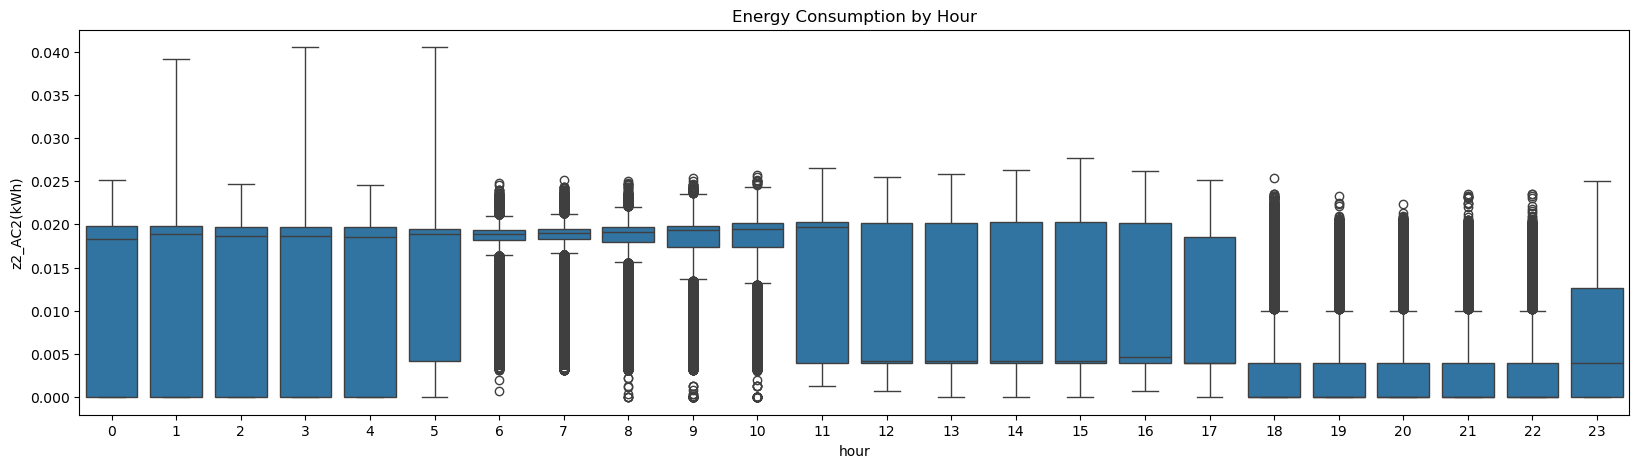

In [8]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x='hour', y=cols[0])
plt.title('Energy Consumption by Hour')
plt.show()

In [83]:
def create_features(df):
    #df['hour'] = df.index.hour
    #df['dayofweek'] = df.index.dayofweek
    #df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    return df

In [84]:
create_features(df)

,z2_AC2(kWh),z2_AC2(kW)_imputed,hour,dayofweek,month,target,quarter
Date,,,,,,,
2018-07-01 00:00:00,0.0,0.0,0,6,7,0.0,3
2018-07-01 00:01:00,0.0,0.0,0,6,7,0.0,3
2018-07-01 00:02:00,0.0,0.0,0,6,7,0.0,3
2018-07-01 00:03:00,0.0,0.0,0,6,7,0.0,3
2018-07-01 00:04:00,0.0,0.0,0,6,7,0.0,3
...,...,...,...,...,...,...,...
2019-12-31 23:51:00,0.0,0.0,23,1,12,0.0,4
2019-12-31 23:52:00,0.0,0.0,23,1,12,0.0,4
2019-12-31 23:53:00,0.0,0.0,23,1,12,0.0,4


### Resampling from 1-min interval to 1-hour interval

In [85]:
df_hour = df.resample('1h').mean().copy()
df_hour = df_hour.drop(columns=['z2_AC2(kW)_imputed'])

In [133]:
# target 
df_hour['target'] = df_hour['z2_AC2(kWh)'].shift(-4)  # 4-hour ahead prediction

# Create lag features
for i in range(1, 31):
    df_hour[f't-{i}'] = df_hour['z2_AC2(kWh)'].shift(i)

# Drop the Nans created from the shifting
df_hour.dropna(inplace=True)

# Define max look-back
max_lookback = 30  # or 32, or however many you want

# Generate all look-back combinations from t-1 to t-max_lookback
lag_feature_combination = [
    [f't-{i}' for i in range(1, n + 1)] for n in range(1, max_lookback + 1)
]

base_features = ['z2_AC2(kWh)', 'hour']

In [146]:
n_lag_features = 0
cvrmse_plot = []
rmse_plot = []
for lag_features in lag_feature_combination:

    features = base_features + lag_features
    X = df_hour[features]
    y = df_hour['target']

    tscv = TimeSeriesSplit(n_splits=5)
    errors = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRFRegressor(
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Compute RMSE and CVRMSE manually
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        cvrmse = (rmse / y_test.mean()) * 100

        errors.append((rmse, cvrmse))

    avg_rmse = sum(e[0] for e in errors) / len(errors)
    avg_cvrmse = sum(e[1] for e in errors) / len(errors)
    print(f"Features: {n_lag_features} + base → Avg RMSE: {avg_rmse:.8f} | Avg CVRMSE: {avg_cvrmse:.2f}%")
    cvrmse_plot.append(avg_cvrmse)
    rmse_plot.append(avg_rmse)
    n_lag_features += 1

Features: 0 + base → Avg RMSE: 0.00385969 | Avg CVRMSE: 37.88%
Features: 1 + base → Avg RMSE: 0.00378079 | Avg CVRMSE: 37.15%
Features: 2 + base → Avg RMSE: 0.00380751 | Avg CVRMSE: 37.41%
Features: 3 + base → Avg RMSE: 0.00376591 | Avg CVRMSE: 36.99%
Features: 4 + base → Avg RMSE: 0.00376312 | Avg CVRMSE: 36.95%
Features: 5 + base → Avg RMSE: 0.00371650 | Avg CVRMSE: 36.53%
Features: 6 + base → Avg RMSE: 0.00353095 | Avg CVRMSE: 34.76%
Features: 7 + base → Avg RMSE: 0.00358713 | Avg CVRMSE: 35.31%
Features: 8 + base → Avg RMSE: 0.00357632 | Avg CVRMSE: 35.21%
Features: 9 + base → Avg RMSE: 0.00361816 | Avg CVRMSE: 35.62%
Features: 10 + base → Avg RMSE: 0.00358240 | Avg CVRMSE: 35.25%
Features: 11 + base → Avg RMSE: 0.00361604 | Avg CVRMSE: 35.56%
Features: 12 + base → Avg RMSE: 0.00365211 | Avg CVRMSE: 35.88%
Features: 13 + base → Avg RMSE: 0.00354052 | Avg CVRMSE: 34.81%
Features: 14 + base → Avg RMSE: 0.00356297 | Avg CVRMSE: 35.03%
Features: 15 + base → Avg RMSE: 0.00367414 | Avg C

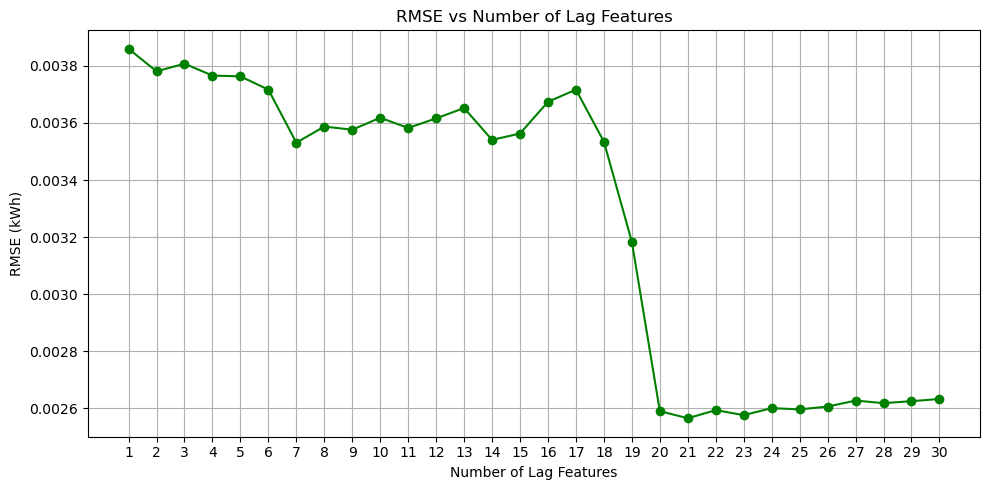

In [150]:
# Plotting RMSE vs. Number of Lag Features
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmse_plot) + 1), rmse_plot, marker='o', linestyle='-', c='green')
plt.title("RMSE vs Number of Lag Features")
plt.xlabel("Number of Lag Features")
plt.ylabel("RMSE (kWh)")
plt.grid(True)
plt.xticks(range(1, len(rmse_plot) + 1))  
plt.tight_layout()
plt.show()

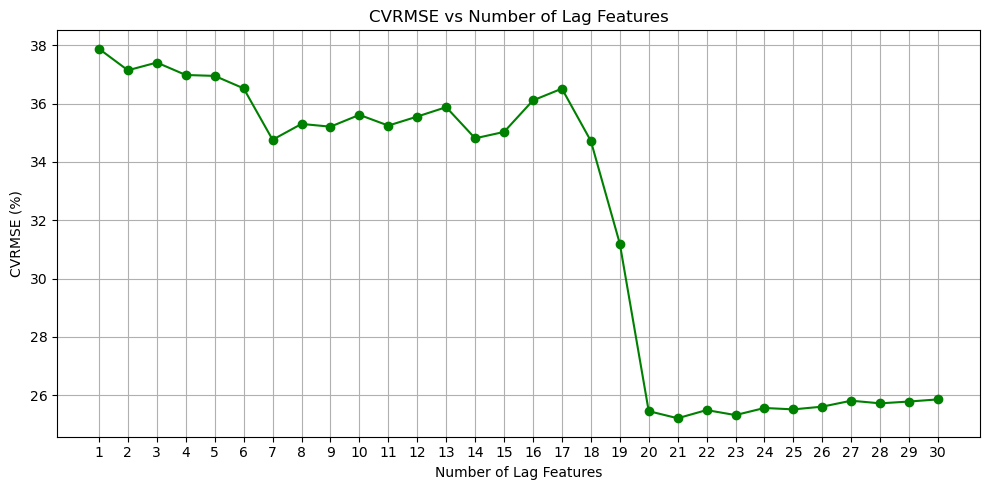

In [148]:
# Plotting CVRMSE vs. Number of Lag Features
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cvrmse_plot) + 1), cvrmse_plot, marker='o', linestyle='-', c='green')
plt.title("CVRMSE vs Number of Lag Features")
plt.xlabel("Number of Lag Features")
plt.ylabel("CVRMSE (%)")
plt.grid(True)
plt.xticks(range(1, len(cvrmse_plot) + 1))  
plt.tight_layout()
plt.show()


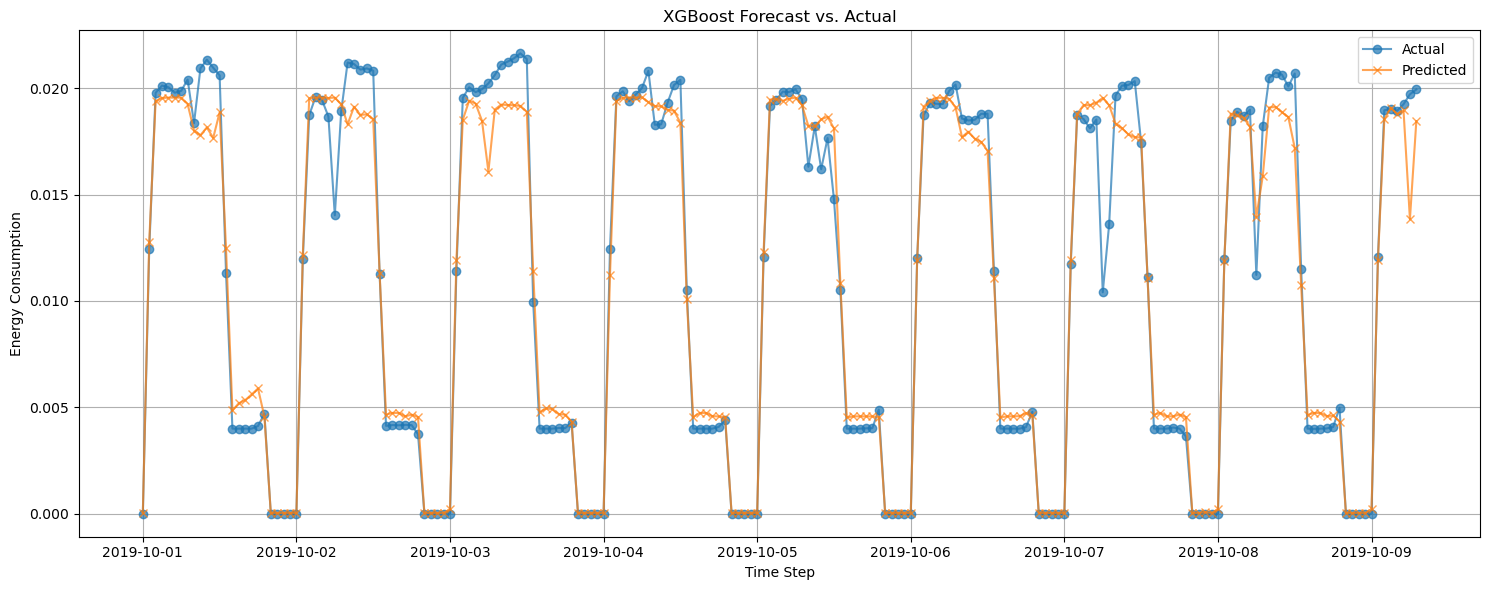

In [149]:

y_pred_series = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(15, 6))
plt.plot(y_test[:200], label='Actual', marker='o', alpha=0.7)
plt.plot(y_pred_series[:200], label='Predicted', marker='x', alpha=0.7)
plt.title('XGBoost Forecast vs. Actual')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
